# <center> $\boxed{\text{Project DSOML}}$ </center>

Sophie OUILLADE and Satyanarayanan VENGATHESA SARMA 

**Project n°1 : **
    
    
Implement the SDCA algorithm to estimate Support Vector Machines. Test the algorithm on databases of your choice and compare it with a sub-gradient descent approach such as PEGASOS.

# Utils

These functions will be used throughout the notebook

In [3]:
%pylab inline
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

np.random.seed(10)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# To compute the sum of individual hinge losses :
def sum_hinge(y, X, w, n_samples):
    losses = np.fmax(np.zeros(n_samples), np.ones(n_samples) - (y * (X.dot(w))))
    return sum(losses)

In [3]:
# To get the accuracy of linear SVM for a given parameter w :
def get_accuracy(X, y, w):
    preds = np.dot(X, w)
    preds[preds > 0] = 1
    preds[preds < 0] = -1
    return accuracy_score(y, preds)

In [4]:
# Function to compare the convergence of various primal curves :
def comparaison_convergence_plot(histories, labels, xlim=[None, None], ylim=[None, None], title="Convergence plot",
                                xticklabels = [None, None, None]):
    f, ax = plt.subplots(1, figsize = (15,7))
    if (xlim != [None, None]):
        ax.set_xlim(xlim)
    if (ylim != [None, None]):
        ax.set_ylim(ylim)
    if (xticklabels != [None, None, None]):
        ax.set_xticklabels(xticklabels)
    for i in range(len(labels)) :
        plt.plot(histories[i], label = labels[i])
    plt.title(title)
    plt.ylabel("Primal Objective")
    plt.xlabel("Iterations")
    plt.legend(loc="best")
    plt.show()

In [5]:
# Function to compare the estimated parameters with the true ones for simulated data :
color_point = ['bo', 'go', 'ro', 'mo', 'ko']
color_line = ['b', 'g', 'r', 'm', 'k']
def comparaison_parameter(param, labels, lim=[None, None]):
    f, ax = plt.subplots(1, figsize = (15,7))
    if (lim != [None, None]):
        ax.set_ylim(lim)
    for i in range(len(labels)) :
        plt.stem(range(len(param[i])), param[i], color_line[i], markerfmt=color_point[i], label=labels[i])
    plt.title("Difference between parameters")
    plt.ylabel("")
    plt.xlabel("Coordonate")
    plt.legend(loc="best")
    plt.show

# I. Algorithms

## I.1. SDCA Implementation

In [6]:
# To get the primal parameter w associated to a dual parameter alpha :
def primal_param(X, alpha, lambd, n_samples):
    return (1 / (lambd * n_samples)) * (np.dot(np.transpose(X), alpha))

In [7]:
# Used for computing the update of SDCA (see the report) :
def get_delta_alpha_q(X, y, alpha, q, lambd, n_samples, w):
    A = (1 / (lambd * n_samples)) * (np.dot(np.transpose(X[q]), X[q]))
    B = np.dot(np.transpose(X[q]) , w)
    delta_alpha_tilde_q = (y[q] - B) / A
    return y[q] * max(0 , min(1 , y[q]*(delta_alpha_tilde_q + alpha[q]))) - alpha[q] 

In [8]:
def SDCA_SVM(X, y, n_samples, T_0, lambd, nb_epochs=50, iteration="random", average=True, 
             keep_full_primal_history=True):

    # initialization of alpha to a vector of zeros
    alpha = np.zeros(n_samples)
    # initialization of histories
    w_history = []
    primal_history = []
    w = primal_param(X, alpha, lambd, n_samples)

    # main loop : random sampling
    if (iteration == "random"):
        for t in range(n_samples * nb_epochs):
            # pick random sample
            q = np.random.randint(0, n_samples)
            # compute and apply SDCA update rule
            delta_alpha_q = get_delta_alpha_q(X, y, alpha, q, lambd, n_samples, w)
            e = np.zeros(n_samples)
            e[q] = 1
            sdca_update = e * delta_alpha_q
            alpha = alpha + sdca_update
            w = primal_param(X, alpha, lambd, n_samples)
            
            # histories updates
            if (average == True):
                w_history.append(w)
            if (keep_full_primal_history == True):
                primal_history.append(sum_hinge(y, X, w, n_samples) / n_samples + (lambd / 2) * np.linalg.norm(w)**2)
            # if it's too costly too keep the full primal history, keep at least some values to get an idea
            if (keep_full_primal_history == False and n_samples > 50000 and t % 50000 == 0):
                primal_history.append(sum_hinge(y, X, w, n_samples) / n_samples + (lambd / 2) * np.linalg.norm(w)**2)
    
    # main loop : permutation sampling
    elif (iteration == "permutation"):
        count = 0
        for t in range(nb_epochs):
            perm = np.random.permutation(n_samples)
            for q in perm :
                # compute and apply SDCA update rule
                delta_alpha_q = get_delta_alpha_q(X, y, alpha, q, lambd, n_samples, w)
                e = np.zeros(n_samples)
                e[q] = 1
                sdca_update = e * delta_alpha_q
                alpha = alpha + sdca_update
                w = primal_param(X, alpha, lambd, n_samples)

                # histories updates
                if (average == True):
                    w_history.append(w)
                if (keep_full_primal_history == True):
                    primal_history.append(sum_hinge(y, X, w, n_samples) / n_samples + (lambd / 2) * np.linalg.norm(w)**2)
                # if it's too costly too keep the full primal history, keep at least some values to get an idea
                if (keep_full_primal_history == False and n_samples > 50000 and count % 50000 == 0):
                    primal_history.append(sum_hinge(y, X, w, n_samples) / n_samples + (lambd / 2) * np.linalg.norm(w)**2)
                count +=1

    # main loop : cyclic sampling
    elif (iteration == "cyclic"):
        count = 0
        perm = np.random.permutation(n_samples)
        for t in range(nb_epochs):
            for q in perm :
                # compute and apply SDCA update rule
                delta_alpha_q = get_delta_alpha_q(X, y, alpha, q, lambd, n_samples, w)
                e = np.zeros(n_samples)
                e[q] = 1
                sdca_update = e * delta_alpha_q
                alpha = alpha + sdca_update
                w = primal_param(X, alpha, lambd, n_samples)

                # histories updates
                if (average == True):
                    w_history.append(w)
                if (keep_full_primal_history == True):
                    primal_history.append(sum_hinge(y, X, w, n_samples) / n_samples + (lambd / 2) * np.linalg.norm(w)**2)
                # if it's too costly too keep the full primal history, keep at least some values to get an idea
                if (keep_full_primal_history == False and n_samples > 50000 and count % 50000 == 0):
                    primal_history.append(sum_hinge(y, X, w, n_samples) / n_samples + (lambd / 2) * np.linalg.norm(w)**2)
                count +=1
                
    if (average == True):
        return asarray(w_history[T_0:]).mean(axis = 0), w_history, primal_history
    else :
        return w, primal_history

## I.2. Pegasos implementation

Very similar to SGD except : 

1) We compute sub-gradients and not gradients at each steps 

2) The step size is always $\frac{1}{\lambda t}$

In [9]:
# Subgradient for the hinge-loss (partial because is it computed for only one individual q) :
def partial_sub_gradient(w, X, y, q, lambd):
    if ( y[q]*np.dot(w, X[q]) < 1 ):
        return lambd * w - y[q] * X[q]
    else:
        return lambd * w

In [10]:
def PEGASOS_SVM(X, y, n_samples, T_0, lambd, nb_epochs=50, proj=False, average=True, keep_full_primal_history=True):

    # initialization of w to a vector of zeros
    w = np.zeros(X.shape[1])
    # initialization of histories
    w_history = []
    primal_history = []
    
    # main loop
    for t in range(1, n_samples * nb_epochs):
        # compute Pegasos step size
        step_size = 1 / (lambd * t)
        # pick random sample
        q = np.random.randint(0, n_samples)
        # compute and apply Pegasos update rule
        w = w - step_size * partial_sub_gradient(w, X, y, q, lambd)
        # projection step (optional)
        if (proj == True):
            w = min(1, 1 / (np.sqrt(lambd) * np.linalg.norm(w))) * w
        # histories updates
        if (average == True):
            w_history.append(w)
        if (keep_full_primal_history == True):
            primal_history.append(sum_hinge(y, X, w, n_samples) / n_samples + (lambd / 2) * np.linalg.norm(w)**2)
        # if it's too costly too keep the full primal history, keep at least some values to get an idea
        if (keep_full_primal_history == False and n_samples > 50000 and t % 50000 == 0):
            primal_history.append(sum_hinge(y, X, w, n_samples) / n_samples + (lambd / 2) * np.linalg.norm(w)**2)
    
    if (average == True):
        return asarray(w_history[T_0:]).mean(axis = 0), w_history, primal_history
    else :
        return w, primal_history

## I.3. Accelerated mini-batch SDCA implementation

For accelerated mini-batch SDCA, the smooth version of the hinge loss is used, unlike for SDCA and Pegasos

In [11]:
# Gradient of the smooth hinge loss :
def partial_gradient_smooth(w, X, y, q):
    if (0 <= y[q] * np.dot(X[q], w) <= 1 ):
        return (y[q] * np.dot(X[q], w) - 1) * y[q] * X[q]
    if (y[q] * np.dot(w, X[q]) < 0 ):
        return - y[q] * X[q]
    else:
        return np.zeros(X.shape[1])

In [12]:
def SDCA_SVM_mini_batch(X, y, n_samples, T_0, lambd, batch_size, theta=0.3, nb_epochs=50, average=True,
                        keep_full_primal_history=True):

    # initialization of alpha and w to a vector of zeros
    alpha = np.zeros(shape = (X.shape[1], n_samples))
    bar_alpha = np.mean(alpha, axis=1)
    w = np.zeros(X.shape[1])
    # initialization of histories
    w_history = []
    primal_history = []

    # main loop
    for t in range(n_samples * nb_epochs):
        u = (1 - theta) * w + (theta / lambd) * bar_alpha
        # pick a random mini-batch (sampling)
        batch = np.random.choice(np.arange(0, n_samples), batch_size, replace=False)
        alpha_dif = []
        # compute the update rule for all selected samples
        for q in batch:
            old_alpha_q = alpha[:,q].copy()
            alpha[:,q] = (1 - theta) * alpha[:,q] - theta * partial_gradient_smooth(u, X, y, q)
            alpha_dif.append(alpha[:,q] - old_alpha_q)
        # applying the update
        bar_alpha = bar_alpha + (1 / n_samples) * sum(alpha_dif, axis=0)
        w = (1 - theta) * w + (theta / lambd) * bar_alpha
        # histories updates
        if (average == True):
            w_history.append(w)
        if (keep_full_primal_history == True):
            primal_history.append(sum_hinge(y, X, w, n_samples) / n_samples + (lambd / 2) * np.linalg.norm(w)**2)
        # if it's too costly too keep the full primal history, keep at least some values to get an idea
        if (keep_full_primal_history == False and n_samples > 50000 and t % 50000 == 0):
            primal_history.append(sum_hinge(y, X, w, n_samples) / n_samples + (lambd / 2) * np.linalg.norm(w)**2)
    
    if (average == True):
        return asarray(w_history[T_0:]).mean(axis = 0), w_history, primal_history
    else :
        return w, primal_history

## I.4. Mini-batch Pegasos implementation

In [13]:
def PEGASOS_SVM_mini_batch(X, y, n_samples, T_0, lambd, batch_size, nb_epochs=50, proj=False, average=True,
                           keep_full_primal_history=True):

    # initialization of w to a vector of zeros
    w = np.zeros(X.shape[1])
    # initialization of histories
    w_history = []
    primal_history = []
    
    # main loop
    for t in range(1, n_samples * nb_epochs):
        # compute Pegasos step size
        step_size = 1 / (lambd * t)
        # pick random batch of samples
        batch = np.random.choice(np.arange(0, n_samples), batch_size, replace=False)
        sum_vect = []
        for q in batch:
            if (y[q] * np.dot(X[q], w) < 1):
                sum_vect.append(y[q] * X[q])
            else:
                sum_vect.append(np.zeros(X.shape[1]))
        # compute and apply mini-batch Pegasos update rule
        w = w - step_size * (lambd * w - (1 / batch_size) * sum(sum_vect, axis=0))
        # Projection step (optional)
        if (proj == True):
            w = min(1, 1 / (np.sqrt(lambd) * np.linalg.norm(w))) * w
        # histories updates
        if (average == True):
            w_history.append(w)
        if (keep_full_primal_history == True):
            primal_history.append(sum_hinge(y, X, w, n_samples) / n_samples + (lambd / 2) * np.linalg.norm(w)**2)
        # if it's too costly too keep the full primal history, keep at least some values to get an idea
        if (keep_full_primal_history == False and n_samples > 50000 and t % 50000 == 0):
            primal_history.append(sum_hinge(y, X, w, n_samples) / n_samples + (lambd / 2) * np.linalg.norm(w)**2)
    
    if (average == True):
        return asarray(w_history[T_0:]).mean(axis = 0), w_history, primal_history
    else :
        return w, primal_history

# II. Simulated data

In [14]:
n_samples, n_features = 1000, 10
# Feature matrix
# First array is person number 1, second array is person number 2 etc
X = np.random.randn(n_samples, n_features)
# true parameter
beta = np.random.randn(n_features)
# Binary label vector
y = np.dot(X, beta) + np.random.randn(n_samples)
y[y > 0] = 1
y[y < 0] = -1

In [15]:
# Standardisation of features is required before SVM :
X_std = preprocessing.StandardScaler().fit_transform(X)

In [16]:
# Train test split for this dataset :
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.33, random_state=42)
n_samples_train = X_train.shape[0]

## II.1. SDCA

In [17]:
# Computing the parameters and the primal value for all variants of SDCA :

simu_opt_w_sdca_random, simu_primal_hist_sdca_random = SDCA_SVM(X_train, y_train, n_samples_train,
                                                    T_0=50 * n_samples // 2, lambd=1 / n_samples,
                                                    iteration="random", average=False) 

simu_opt_w_sdca_permutation, simu_primal_hist_sdca_permutation = SDCA_SVM(X_train, y_train, n_samples_train,
                                                                T_0=50 * n_samples // 2, lambd=1 / n_samples,
                                                                iteration="permutation", average=False)

simu_opt_w_sdca_cyclic, simu_primal_hist_sdca_cyclic = SDCA_SVM(X_train, y_train, n_samples_train,
                                                                T_0=50 * n_samples // 2, lambd=1 / n_samples,
                                                                iteration="cyclic", average=False)

simu_opt_w_sdca_avg_r, simu_w_hist_sdca_avg_r, simu_primal_hist_sdca_avg_r = SDCA_SVM(X_train, y_train,
                                                                            n_samples_train, T_0=50 * n_samples // 2,
                                                                            lambd=1 / n_samples, iteration="random",
                                                                            average=True)

simu_opt_w_sdca_avg_p, simu_w_hist_sdca_avg_p, simu_primal_hist_sdca_avg_p = SDCA_SVM(X_train, y_train,
                                                                            n_samples_train, T_0=50 * n_samples // 2,
                                                                            lambd=1 / n_samples,
                                                                            iteration="permutation", average=True)

simu_opt_w_sdca_avg_c, simu_w_hist_sdca_avg_c, simu_primal_hist_sdca_avg_c = SDCA_SVM(X_train, y_train,
                                                                            n_samples_train, T_0=50 * n_samples // 2,
                                                                            lambd=1 / n_samples, iteration="cyclic",
                                                                            average=True)

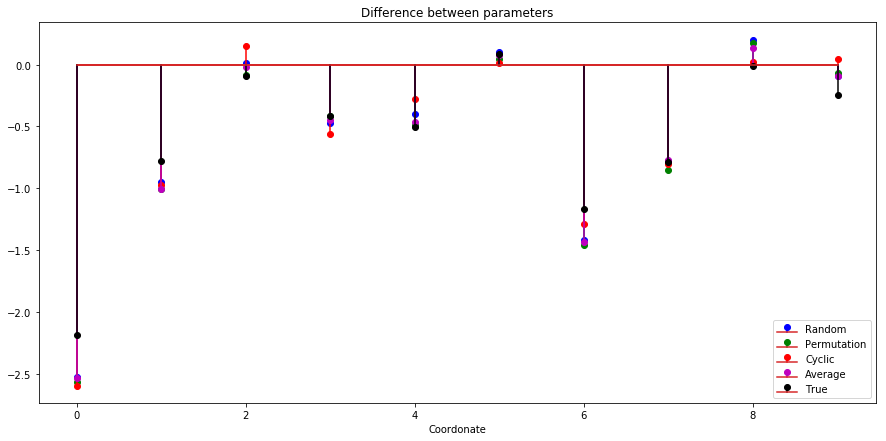

In [18]:
params_simu_sdca = [simu_opt_w_sdca_random, simu_opt_w_sdca_permutation,
                    simu_opt_w_sdca_cyclic, simu_opt_w_sdca_avg_r, beta]
labels_simu_sdca = ["Random", "Permutation", "Cyclic", "Average", "True"]
comparaison_parameter(params_simu_sdca, labels_simu_sdca)

The average option only changes the output vector and not the convergence plot.

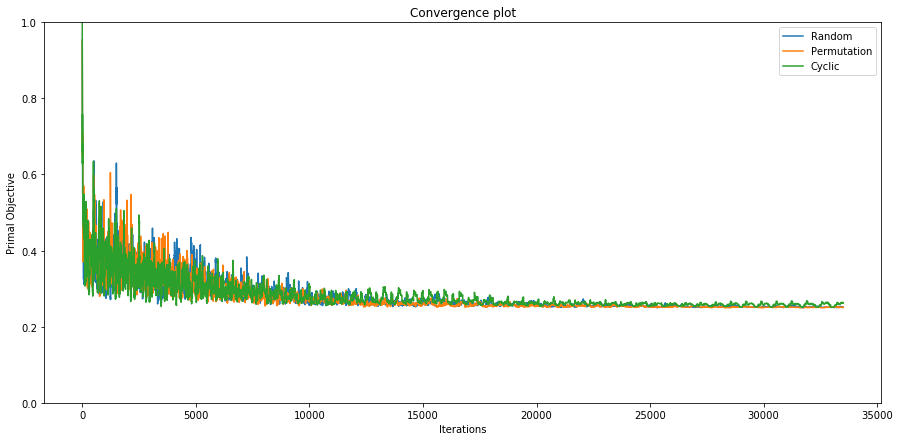

In [19]:
histories_simu_sdca = [simu_primal_hist_sdca_random, simu_primal_hist_sdca_permutation, simu_primal_hist_sdca_cyclic]
labels2_simu_sdca = ["Random", "Permutation", "Cyclic"]
comparaison_convergence_plot(histories_simu_sdca, labels2_simu_sdca, ylim=[0,1])

In [20]:
# Computing prediction accuracy on test set
print("Random")
print(get_accuracy(X_test, y_test, simu_opt_w_sdca_random))
print("Permutation")
print(get_accuracy(X_test, y_test, simu_opt_w_sdca_permutation))
print("Cyclic")
print(get_accuracy(X_test, y_test, simu_opt_w_sdca_cyclic))
print("Average r")
print(get_accuracy(X_test, y_test, simu_opt_w_sdca_avg_r))
print("Average p")
print(get_accuracy(X_test, y_test, simu_opt_w_sdca_avg_p))
print("Average c")
print(get_accuracy(X_test, y_test, simu_opt_w_sdca_avg_c))
print("True")
print(get_accuracy(X_test, y_test, beta))

Random
0.863636363636
Permutation
0.881818181818
Cyclic
0.872727272727
Average r
0.866666666667
Average p
0.875757575758
Average c
0.869696969697
True
0.878787878788


## II.2. Pegasos

In [21]:
# Computing the parameters and the primal value for all variants of Pegasos :

simu_opt_w_peg, simu_primal_hist_peg = PEGASOS_SVM(X_train, y_train, n_samples_train,
                                    T_0=50 * n_samples // 2, lambd=1 / n_samples,
                                    proj=False, average=False)

simu_opt_w_peg_proj, simu_primal_hist_peg_proj = PEGASOS_SVM(X_train, y_train, n_samples_train,
                                                T_0=50 * n_samples // 2, lambd=1 / n_samples,
                                                proj=True, average=False)

simu_opt_w_peg_avg, simu_w_hist_peg_avg, simu_primal_hist_peg_avg = PEGASOS_SVM(X_train, y_train,
                                                                    n_samples_train, T_0=50 * n_samples // 2,
                                                                    lambd=1 / n_samples, proj=False, average=True)

simu_opt_w_peg_avg_p, simu_w_hist_peg_avg_p, simu_primal_hist_peg_avg_p = PEGASOS_SVM(X_train, y_train,
                                                                        n_samples_train, T_0=50 * n_samples // 2,
                                                                        lambd=1 / n_samples, proj=True, average=True)

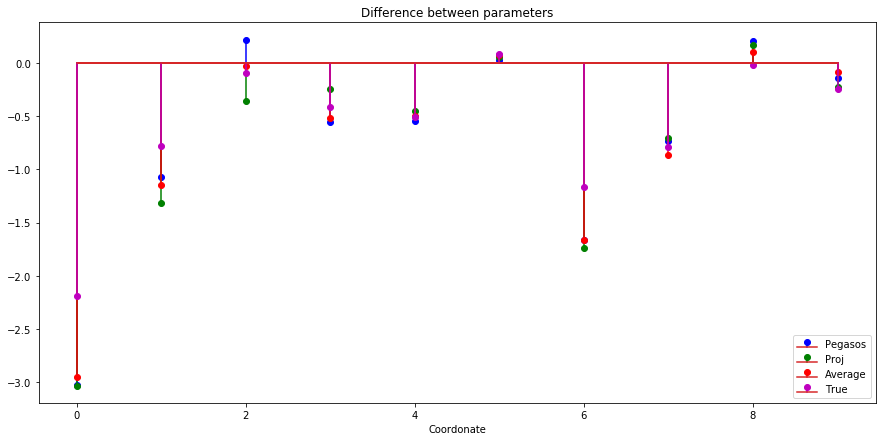

In [22]:
params_simu_peg = [simu_opt_w_peg, simu_opt_w_peg_proj, simu_opt_w_peg_avg, beta]
labels_simu_peg = ["Pegasos", "Proj", "Average", "True"]
comparaison_parameter(params_simu_peg, labels_simu_peg)

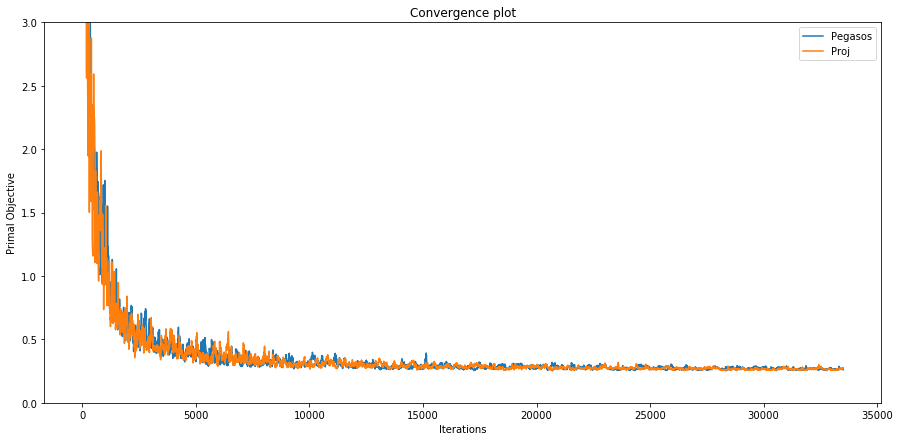

In [23]:
histories_simu_peg = [simu_primal_hist_peg, simu_primal_hist_peg_proj]
labels2_simu_peg = ["Pegasos", "Proj"]
comparaison_convergence_plot(histories_simu_peg, labels2_simu_peg, ylim=[0,3])

In [24]:
# Computing prediction accuracy on test set
print("Pegasos")
print(get_accuracy(X_test, y_test, simu_opt_w_peg))
print("Projected")
print(get_accuracy(X_test, y_test, simu_opt_w_peg_proj))
print("Average")
print(get_accuracy(X_test, y_test, simu_opt_w_peg_avg))
print("Average p")
print(get_accuracy(X_test, y_test, simu_opt_w_peg_avg_p))
print("True")
print(get_accuracy(X_test, y_test, beta))

Pegasos
0.854545454545
Projected
0.875757575758
Average
0.872727272727
Average p
0.875757575758
True
0.878787878788


## II.3. Accelerated mini-batch SDCA

In [25]:
# Computing the parameters and the primal value for all variants of ASDCA :

simu_opt_w_sdca_batch, simu_primal_hist_sdca_batch = SDCA_SVM_mini_batch(X_train, y_train,
                                                    n_samples_train, T_0=50 * n_samples // 2,
                                                    lambd=1 / n_samples, batch_size=8, theta=0.15, average=False)

simu_opt_w_sdca_batch_avg, simu_w_hist_sdca_batch_avg, simu_primal_hist_sdca_batch_avg = SDCA_SVM_mini_batch(X_train, y_train, n_samples_train, T_0=50 * n_samples // 2, lambd=1 / n_samples, batch_size = 8, theta = 0.15, average=True)

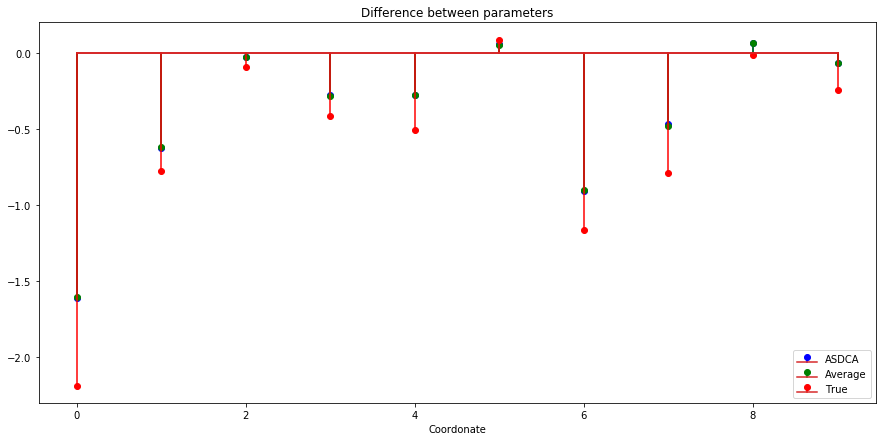

In [26]:
params_simu_sdca_batch = [simu_opt_w_sdca_batch, simu_opt_w_sdca_batch_avg, beta]
labels_simu_sdca_batch = ["ASDCA", "Average", "True"]
comparaison_parameter(params_simu_sdca_batch, labels_simu_sdca_batch)

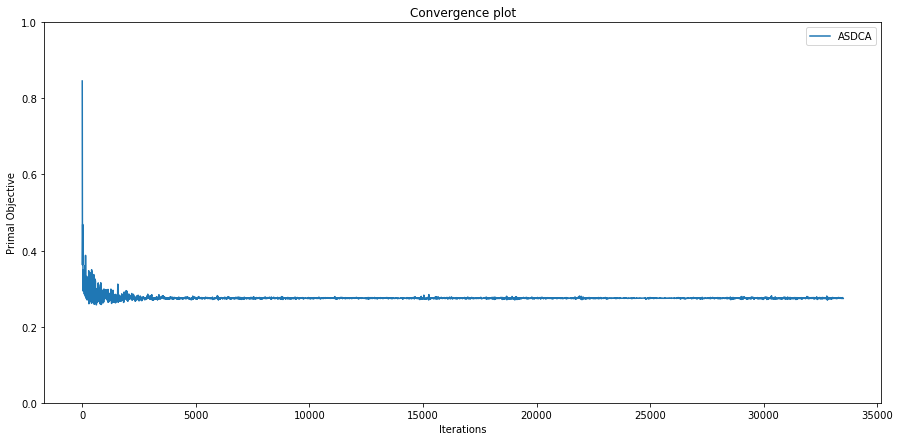

In [27]:
histories_simu_sdca_batch = [simu_primal_hist_sdca_batch]
labels2_simu_sdca_batch = ["ASDCA"]
comparaison_convergence_plot(histories_simu_sdca_batch, labels2_simu_sdca_batch, ylim=[0,1])

In [28]:
# Computing prediction accuracy on test set
print("ASDCA")
print(get_accuracy(X_test, y_test, simu_opt_w_sdca_batch))
print("Average")
print(get_accuracy(X_test, y_test, simu_opt_w_sdca_batch_avg))
print("True")
print(get_accuracy(X_test, y_test, beta))

ASDCA
0.869696969697
Average
0.875757575758
True
0.878787878788


## II.4. Mini-batch Pegasos

In [29]:
# Computing the parameters and the primal value for all variants of mini-batch Pegasos :

simu_opt_w_peg_batch, simu_primal_hist_peg_batch = PEGASOS_SVM_mini_batch(X_train, y_train,
                                                    n_samples_train, T_0=50 * n_samples // 2,
                                                    lambd=1 / n_samples, batch_size=8, proj=False, average=False)

simu_opt_w_peg_batch_proj, simu_primal_hist_peg_batch_proj = PEGASOS_SVM_mini_batch(X_train, y_train,
                                                            n_samples_train, T_0=50 * n_samples // 2,
                                                            lambd=1 / n_samples, batch_size=8,
                                                            proj=True, average=False)

simu_opt_w_peg_batch_avg, simu_w_hist_peg_batch_avg, simu_primal_hist_peg_batch_avg = PEGASOS_SVM_mini_batch(X_train,
                                                                    y_train, n_samples_train, T_0=50 * n_samples // 2,
                                                                    lambd=1 / n_samples, batch_size=8, proj=False,
                                                                    average=True)

simu_opt_w_peg_batch_avg_p, simu_w_hist_peg_batch_avg_p, simu_primal_hist_peg_batch_avg_p = PEGASOS_SVM_mini_batch(X_train, y_train, n_samples_train, T_0=50 * n_samples // 2, lambd=1 / n_samples, batch_size=8, proj=True, average=True)

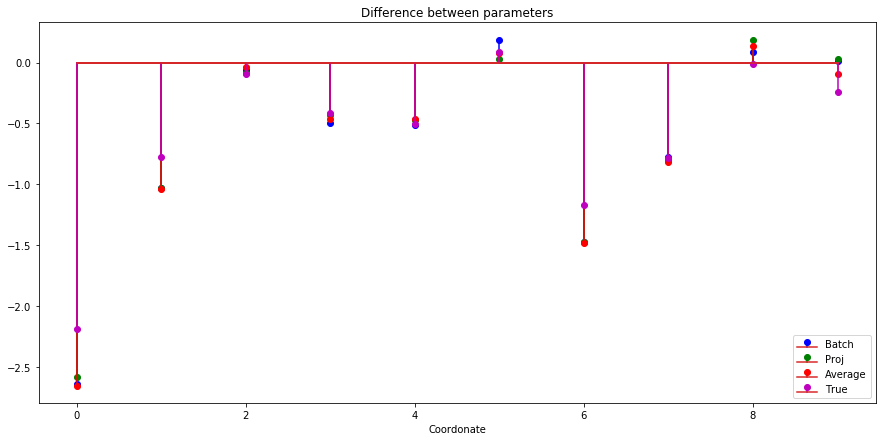

In [30]:
params_simu_peg_batch = [simu_opt_w_peg_batch, simu_opt_w_peg_batch_proj, simu_opt_w_peg_batch_avg, beta]
labels_simu_peg_batch = ["Batch", "Proj", "Average", "True"]
comparaison_parameter(params_simu_peg_batch, labels_simu_peg_batch)

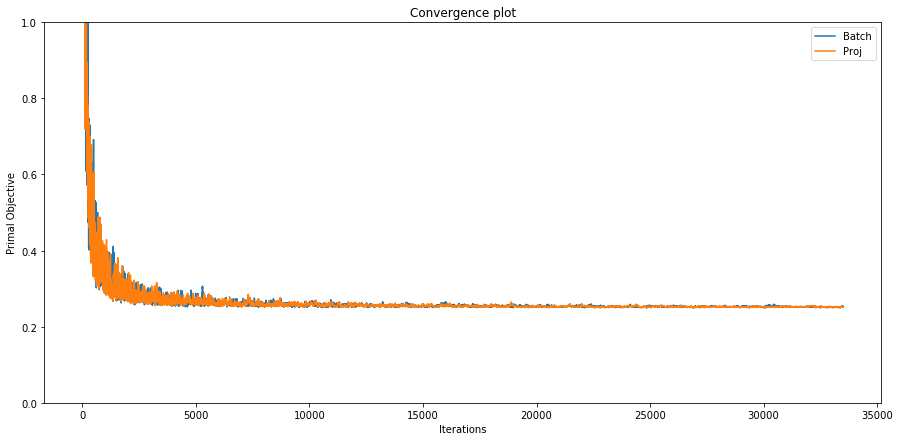

In [31]:
histories_simu_peg_batch = [simu_primal_hist_peg_batch, simu_primal_hist_peg_batch_proj]
labels2_simu_peg_batch = ["Batch", "Proj"]
comparaison_convergence_plot(histories_simu_peg_batch, labels2_simu_peg_batch, ylim=[0,1])

In [32]:
# Computing prediction accuracy on test set
print("Batch")
print(get_accuracy(X_test, y_test, simu_opt_w_peg_batch))
print("Projected")
print(get_accuracy(X_test, y_test, simu_opt_w_peg_batch_proj))
print("Average")
print(get_accuracy(X_test, y_test, simu_opt_w_peg_batch_avg))
print("Average p")
print(get_accuracy(X_test, y_test, simu_opt_w_peg_batch_avg_p))
print("True")
print(get_accuracy(X_test, y_test, beta))

Batch
0.878787878788
Projected
0.875757575758
Average
0.875757575758
Average p
0.878787878788
True
0.878787878788


## II.5. Comparision between all four algorithms

In [33]:
# Accuracy omparison with the native sklearn learner :

# In the native implementation, the penalty parameter is C = 1 / (n_samples * lambda)
# Thus C = 1 (default in sklearn) is equivalent to lambda = 1 / n_samples
# hence the value that we chose for lambda in SDCA and pegasos

LSVM = svm.SVC(kernel = "linear")
model = LSVM.fit(X_train, y_train)
accuracy_score(y_test, model.predict(X_test))

# Very close results (often exactly the same), sometimes SDCA or Pegasos beat the native implementation

0.87272727272727268

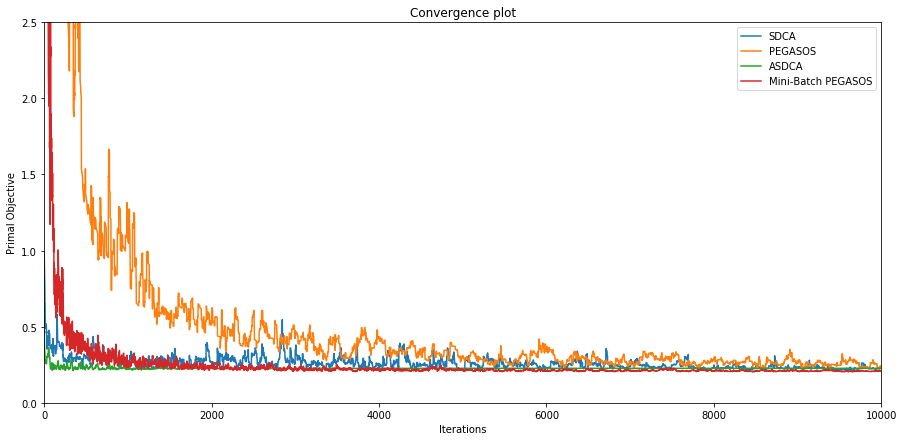

In [207]:
# Convergence comparison :

simu_histories = [simu_primal_hist_sdca_random, simu_primal_hist_peg,
                  simu_primal_hist_sdca_batch, simu_primal_hist_peg_batch]
simu_labels = ["SDCA", "PEGASOS", "ASDCA", "Mini-Batch PEGASOS"]
comparaison_convergence_plot(simu_histories, simu_labels, xlim = [0, 10000], ylim = [0, 2.5])

# III. Genomic cancer data (high dimension data)

Data can be found on the website : http://members.cbio.mines-paristech.fr/~jvert/svn/kernelcourse/course/2017ensae/index.html

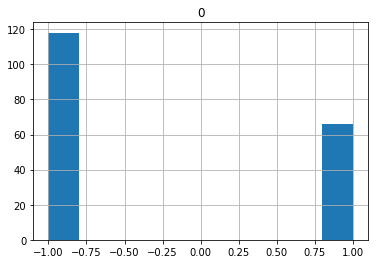

In [4]:
X_train_gen = asarray(pd.read_table("xtrain.txt", delim_whitespace=True, header=None, index_col=0).transpose())
y_train_gen = pd.read_table("ytrain.txt", delim_whitespace=True, header=None)
y_train_gen.hist()
# We want y's index to start from 1 and in the X dataframe, and not from 0 :
y_train_gen.index += 1
# Formatting y_train for usage in sklearn :
y_train_gen = y_train_gen.as_matrix().ravel()

The problem seems to be a little unbalanced

In [6]:
n_samples = X_train_gen.shape[0]
X_train_gen_std = preprocessing.StandardScaler().fit_transform(X_train_gen)

In [7]:
X_train_gen_std.shape

(184, 4654)

Due to the small number of sample, we need to have a big penalization to be sure not to overfit.

## III.1. SDCA

In [103]:
gen_opt_w_sdca_random,      gen_primal_hist_sdca_random           = SDCA_SVM(X_train_gen_std, y_train_gen, n_samples, T_0=50 * n_samples // 2, lambd=50, iteration="random", average=False) 
gen_opt_w_sdca_permutation, gen_primal_hist_sdca_permutation      = SDCA_SVM(X_train_gen_std, y_train_gen, n_samples, T_0=50 * n_samples // 2, lambd=50, iteration="permutation", average=False)
gen_opt_w_sdca_cyclic,      gen_primal_hist_sdca_cyclic           = SDCA_SVM(X_train_gen_std, y_train_gen, n_samples, T_0=50 * n_samples // 2, lambd=50, iteration="cyclic", average=False)
gen_opt_w_sdca_avg, gen_w_hist_sdca_avg, gen_primal_hist_sdca_avg = SDCA_SVM(X_train_gen_std, y_train_gen, n_samples, T_0=50 * n_samples // 2, lambd=50, iteration="random", average=True)

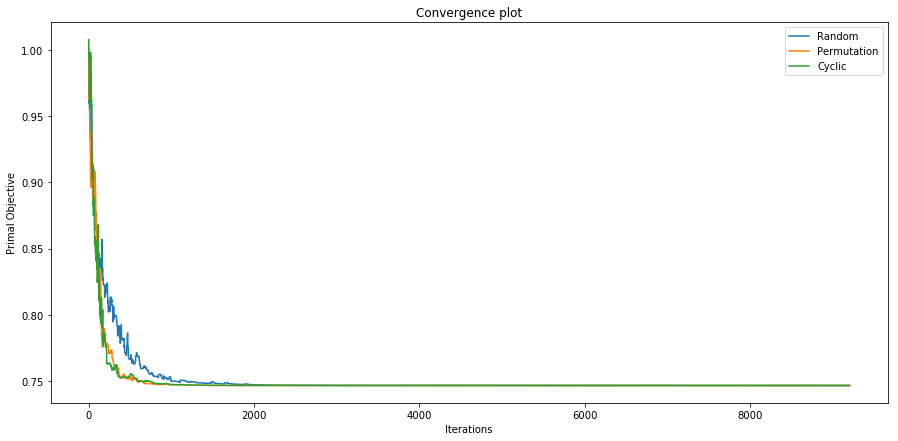

In [116]:
histories_gen_sdca = [gen_primal_hist_sdca_random, gen_primal_hist_sdca_permutation, gen_primal_hist_sdca_cyclic]
labels_gen_sdca = ["Random", "Permutation", "Cyclic"]
comparaison_convergence_plot(histories_gen_sdca, labels_gen_sdca)

## III.2. Pegasos

In [97]:
gen_opt_w_peg,      gen_primal_hist_peg      = PEGASOS_SVM(X_train_gen_std, y_train_gen, n_samples, T_0=50 * n_samples // 2, lambd=50, proj=False, average=False)
gen_opt_w_peg_proj, gen_primal_hist_peg_proj = PEGASOS_SVM(X_train_gen_std, y_train_gen, n_samples, T_0=50 * n_samples // 2, lambd=50, proj=True, average=False)
gen_opt_w_peg_avg, gen_w_hist_peg_avg, gen_primal_hist_peg_avg = PEGASOS_SVM(X_train_gen_std, y_train_gen, n_samples, T_0=50 * n_samples // 2, lambd=50, proj=False, average=True)

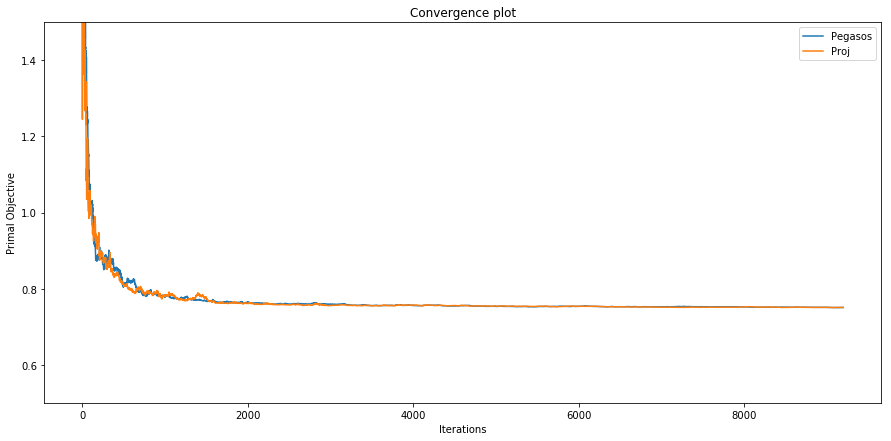

In [117]:
histories_gen_peg = [gen_primal_hist_peg, gen_primal_hist_peg_proj]
labels_gen_peg = ["Pegasos", "Proj"]
comparaison_convergence_plot(histories_gen_peg, labels_gen_peg, ylim=[0.5, 1.5])

In [443]:
# Way more unstable 
# Parameters take a loooong time ton converge compared to SDCA
# The loss takes extremely high values compared to SDCA (max is 200 for SDCA, here it's 700k)
# But a bit faster to converge towards 0

## III.3. Accelerated mini-batch SDCA

In [110]:
gen_opt_w_sdca_batch, gen_primal_hist_sdca_batch = SDCA_SVM_mini_batch(X_train_gen_std, y_train_gen, n_samples, T_0=50 * n_samples // 2, lambd=50, batch_size=8, theta=0.15, average=False)
gen_opt_w_sdca_batch_avg, gen_w_hist_sdca_batch_avg, gen_primal_hist_sdca_batch_avg = SDCA_SVM_mini_batch(X_train_gen_std, y_train_gen, n_samples, T_0=50 * n_samples // 2, lambd=50, batch_size = 8, theta = 0.15, average=True)

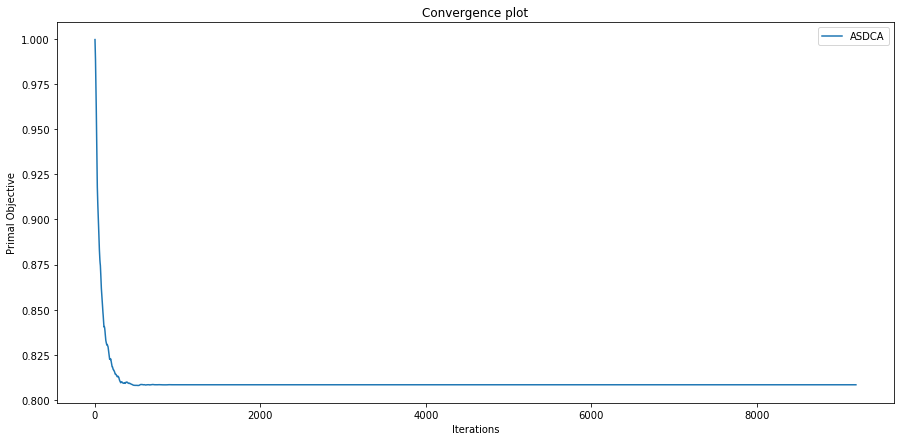

In [118]:
histories_gen_sdca_batch = [gen_primal_hist_sdca_batch]
labels_gen_sdca_batch = ["ASDCA"]
comparaison_convergence_plot(histories_gen_sdca_batch, labels_gen_sdca_batch)

## III.4. Mini-batch Pegasos

In [113]:
gen_opt_w_peg_batch,      gen_primal_hist_peg_batch      = PEGASOS_SVM_mini_batch(X_train_gen_std, y_train_gen, n_samples, T_0=50 * n_samples // 2, lambd=50, batch_size=8, proj=False, average=False)
gen_opt_w_peg_batch_proj, gen_primal_hist_peg_batch_proj = PEGASOS_SVM_mini_batch(X_train_gen_std, y_train_gen, n_samples, T_0=50 * n_samples // 2, lambd=50, batch_size=8, proj=True, average=False)
gen_opt_w_peg_batch_avg, gen_w_hist_peg_batch_avg, gen_primal_hist_peg_batch_avg = PEGASOS_SVM_mini_batch(X_train_gen_std, y_train_gen, n_samples, T_0=50 * n_samples // 2, lambd=50, batch_size=8, proj=False, average=True)

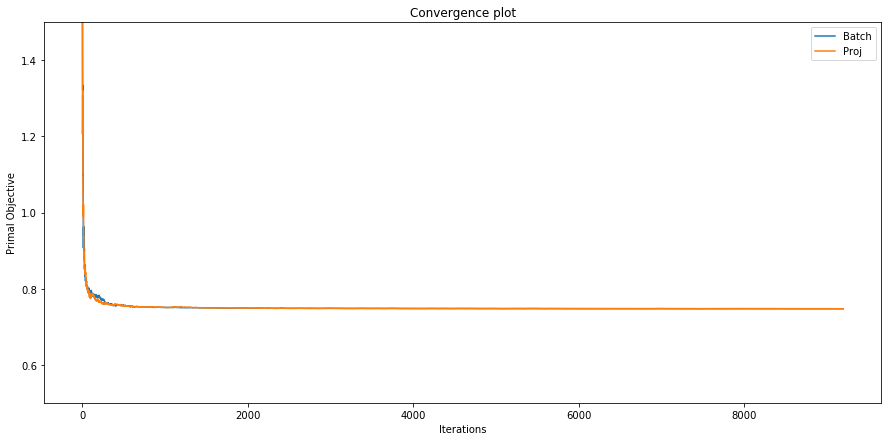

In [120]:
histories_gen_peg_batch = [gen_primal_hist_peg_batch, gen_primal_hist_peg_batch_proj]
labels_gen_peg_batch = ["Batch", "Proj"]
comparaison_convergence_plot(histories_gen_peg_batch, labels_gen_peg_batch, ylim=[0.5, 1.5])

## III.5. Comparision between all four algorithms

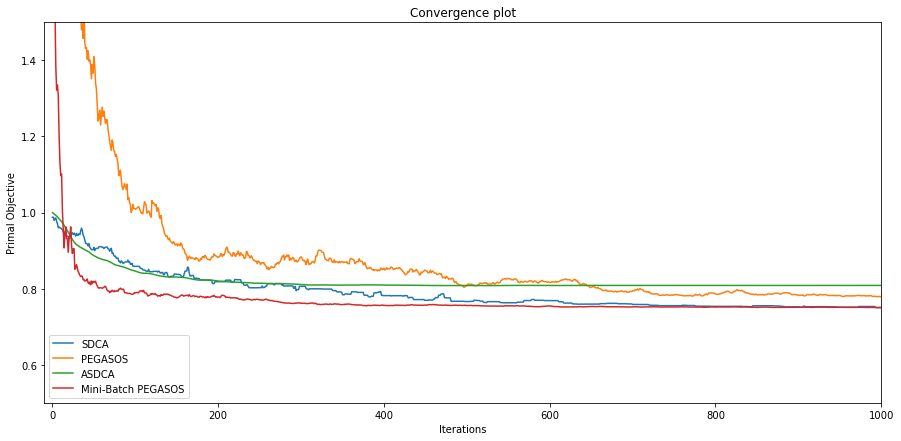

In [123]:
# All simulations
simu_histories = [gen_primal_hist_sdca_random, gen_primal_hist_peg, gen_primal_hist_sdca_batch, gen_primal_hist_peg_batch]
simu_labels = ["SDCA", "PEGASOS", "ASDCA", "Mini-Batch PEGASOS"]
comparaison_convergence_plot(simu_histories, simu_labels, xlim = [-10, 1000], ylim = [0.5, 1.5])

## III.6. Influence of $\lambda$

lambda = 10


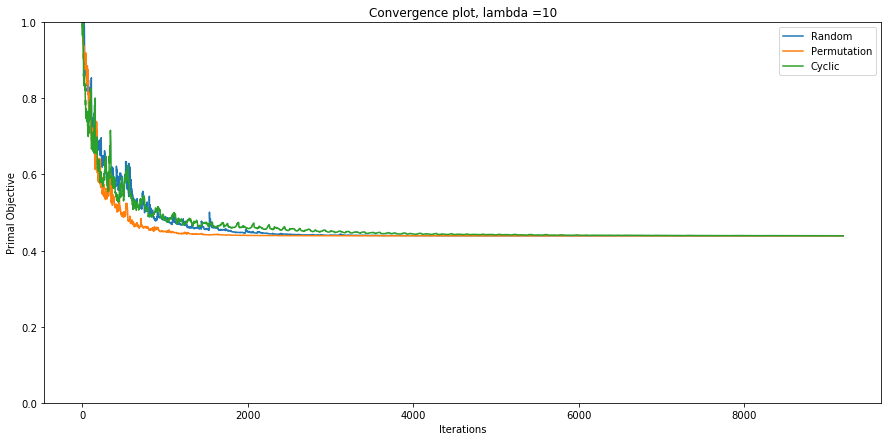

Random
0.934782608696
Permutation
0.934782608696
Cyclic
0.934782608696
Average
0.934782608696
 
lambda = 1


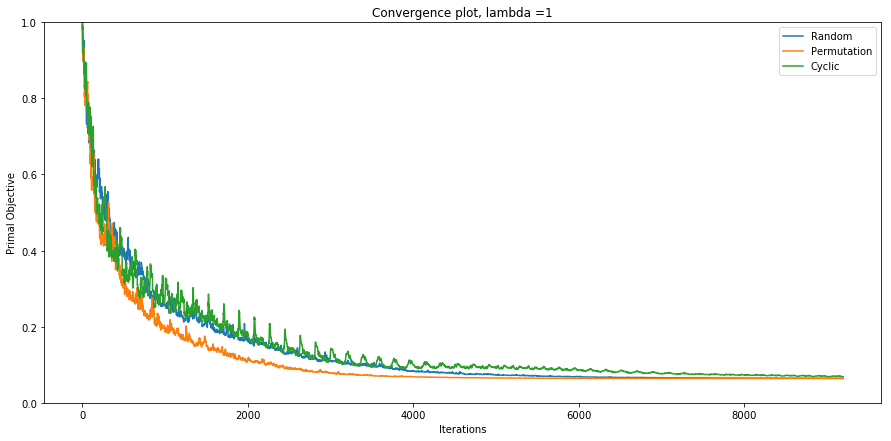

Random
1.0
Permutation
1.0
Cyclic
1.0
Average
1.0
 
lambda = 0.1


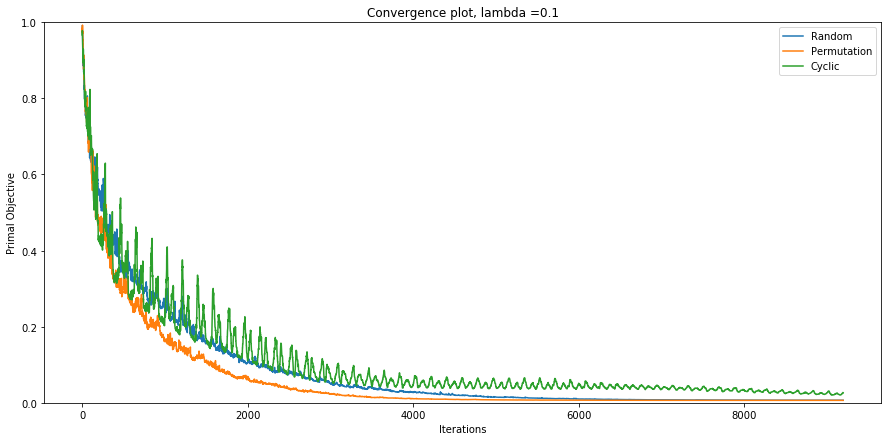

Random
1.0
Permutation
1.0
Cyclic
1.0
Average
1.0
 
lambda = 0.01


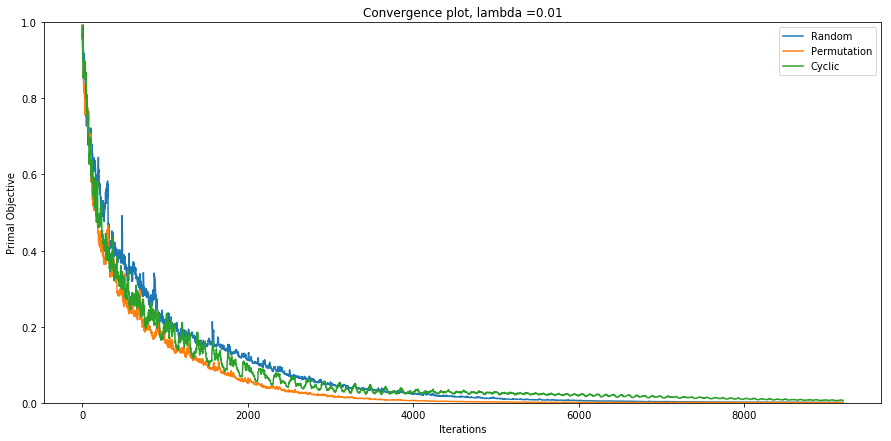

Random
1.0
Permutation
1.0
Cyclic
1.0
Average
1.0
 
lambda = 0.001


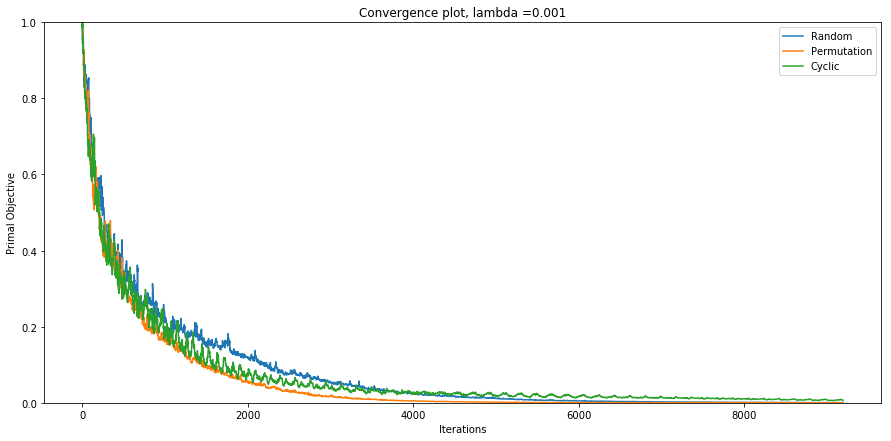

Random
1.0
Permutation
1.0
Cyclic
1.0
Average
1.0
 


In [124]:
# SDCA

lambdas = [10, 1, 0.1, 0.01, 0.001]
for l in lambdas :
    print("lambda = " + str(l))
    # calculs
    gen_opt_w_sdca_random,      gen_primal_hist_sdca_random           = SDCA_SVM(X_train_gen_std, y_train_gen, n_samples, T_0=50 * n_samples // 2, lambd=l, iteration="random", average=False) 
    gen_opt_w_sdca_permutation, gen_primal_hist_sdca_permutation      = SDCA_SVM(X_train_gen_std, y_train_gen, n_samples, T_0=50 * n_samples // 2, lambd=l, iteration="permutation", average=False)
    gen_opt_w_sdca_cyclic,      gen_primal_hist_sdca_cyclic           = SDCA_SVM(X_train_gen_std, y_train_gen, n_samples, T_0=50 * n_samples // 2, lambd=l, iteration="cyclic", average=False)
    gen_opt_w_sdca_avg, gen_w_hist_sdca_avg, gen_primal_hist_sdca_avg = SDCA_SVM(X_train_gen_std, y_train_gen, n_samples, T_0=50 * n_samples // 2, lambd=l, iteration="random", average=True)
    
    # plots
    histories_gen_sdca = [gen_primal_hist_sdca_random, gen_primal_hist_sdca_permutation, gen_primal_hist_sdca_cyclic]
    labels_gen_sdca = ["Random", "Permutation", "Cyclic"]
    comparaison_convergence_plot(histories_gen_sdca, labels_gen_sdca, ylim=[0,1], title="Convergence plot, lambda ="+str(l))

lambda = 10


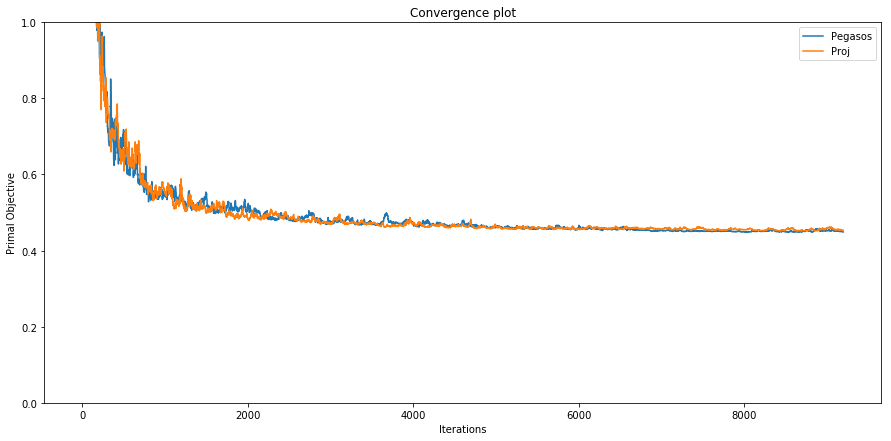

Pegasos
0.934782608696
Projected
0.934782608696
Average
0.951086956522
lambda = 1


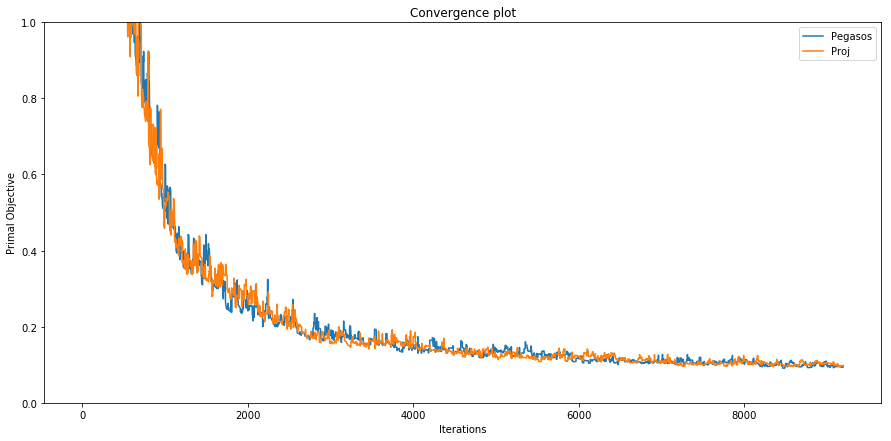

Pegasos
1.0
Projected
1.0
Average
1.0
lambda = 0.1


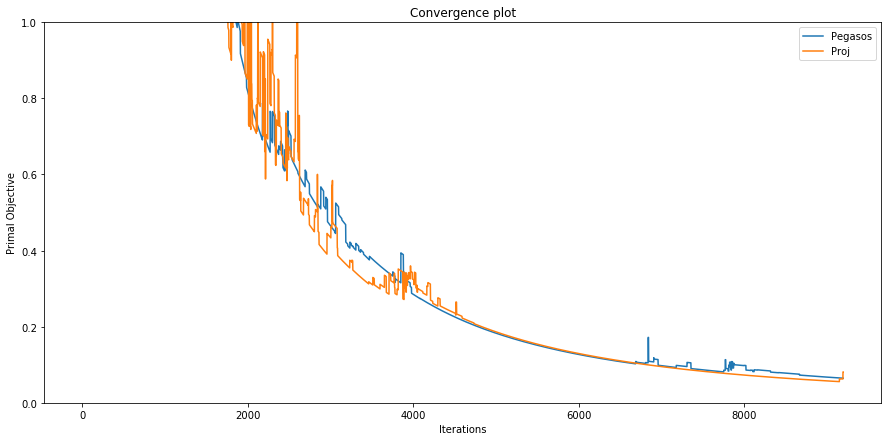

Pegasos
1.0
Projected
1.0
Average
1.0
lambda = 0.01


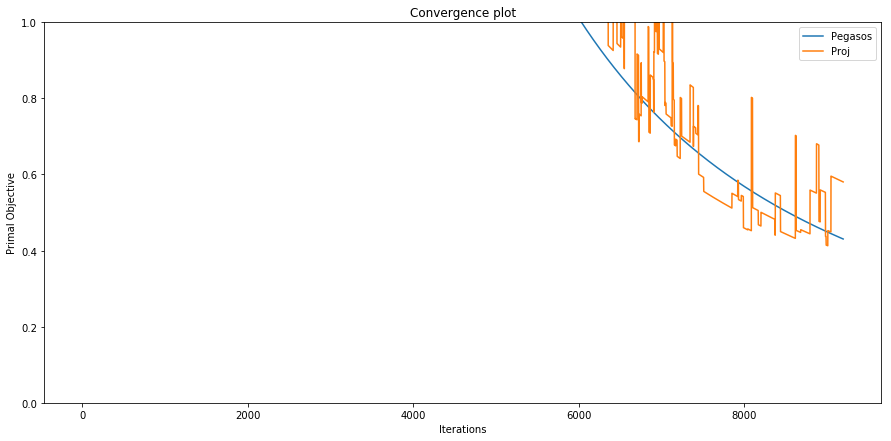

Pegasos
1.0
Projected
0.972826086957
Average
1.0
lambda = 0.001


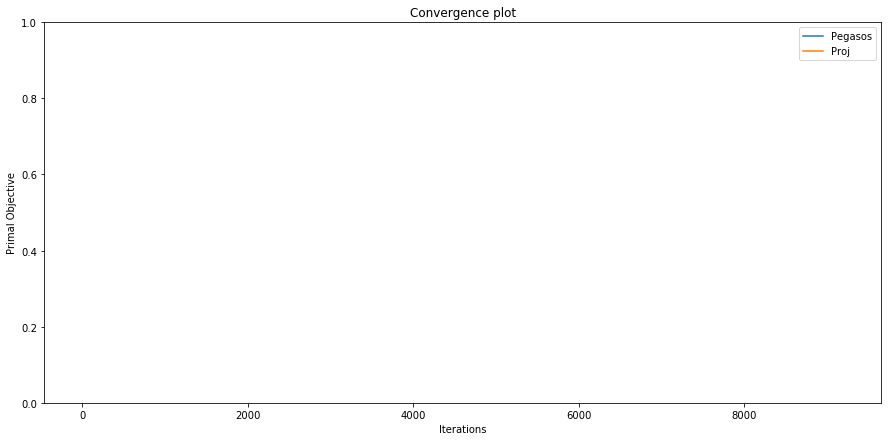

Pegasos
1.0
Projected
0.673913043478
Average
1.0


In [125]:
# PEGASOS

lambdas = [10, 1, 0.1, 0.01, 0.001]
for l in lambdas :
    print("lambda = " + str(l))
    # calculs
    gen_opt_w_peg,      gen_primal_hist_peg      = PEGASOS_SVM(X_train_gen_std, y_train_gen, n_samples, T_0=50 * n_samples // 2, lambd=l, proj=False, average=False)
    gen_opt_w_peg_proj, gen_primal_hist_peg_proj = PEGASOS_SVM(X_train_gen_std, y_train_gen, n_samples, T_0=50 * n_samples // 2, lambd=l, proj=True, average=False)
    gen_opt_w_peg_avg, gen_w_hist_peg_avg, gen_primal_hist_peg_avg = PEGASOS_SVM(X_train_gen_std, y_train_gen, n_samples, T_0=50 * n_samples // 2, lambd=l, proj=False, average=True)
    
    # plots
    histories_gen_peg = [gen_primal_hist_peg, gen_primal_hist_peg_proj]
    labels_gen_peg = ["Pegasos", "Proj"]
    comparaison_convergence_plot(histories_gen_peg, labels_gen_peg, ylim=[0,1])

lambda = 10


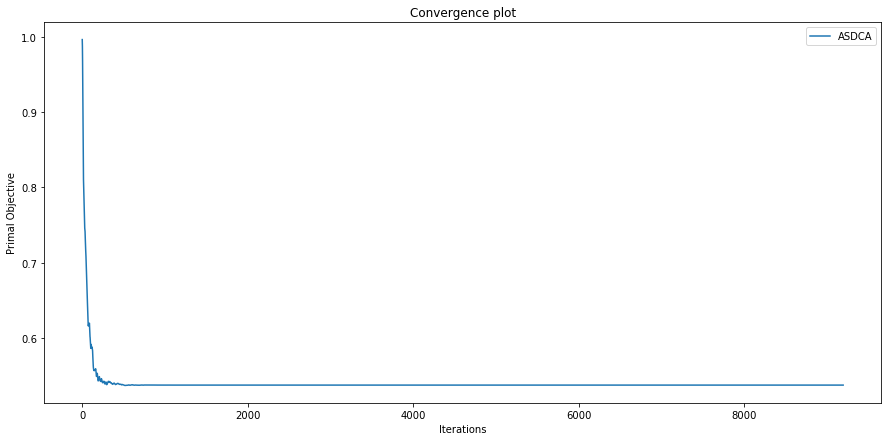

ASDCA
1.0
Average
1.0
lambda = 1


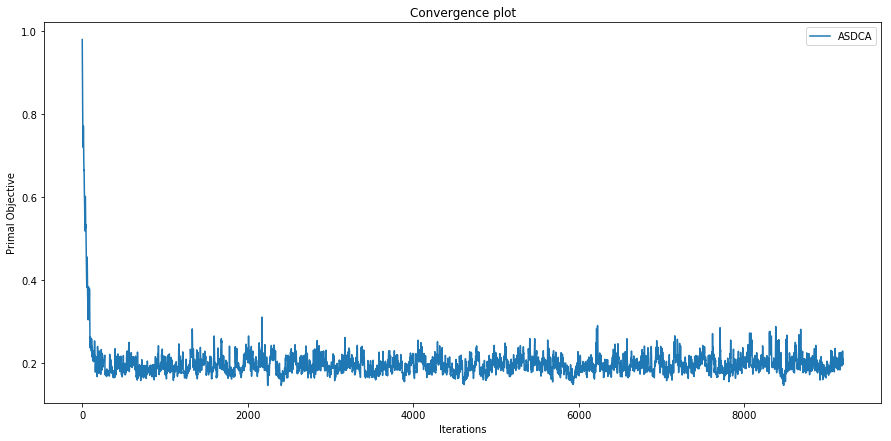

ASDCA
0.983695652174
Average
1.0
lambda = 0.1


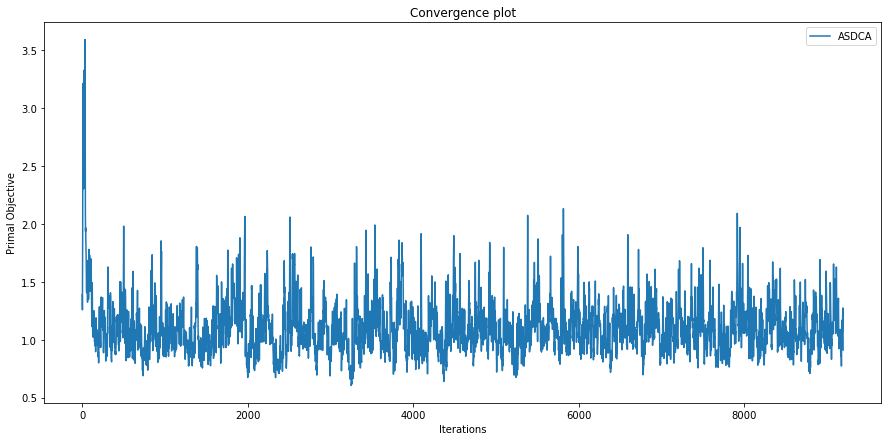

ASDCA
0.929347826087
Average
1.0
lambda = 0.01


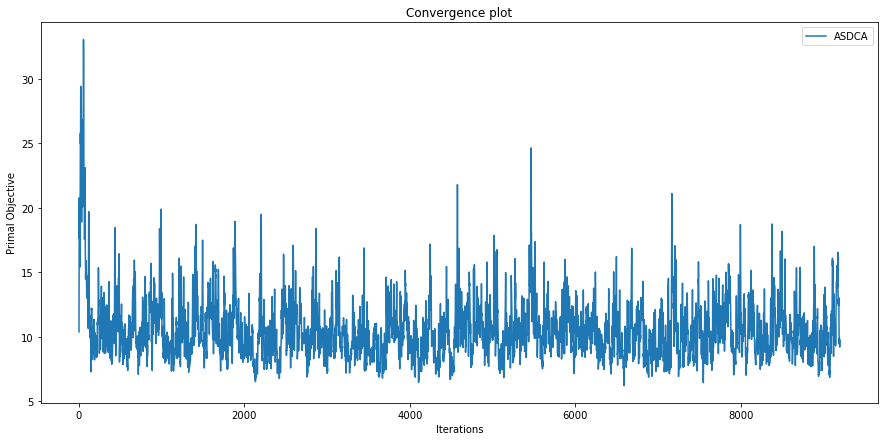

ASDCA
0.907608695652
Average
1.0
lambda = 0.001


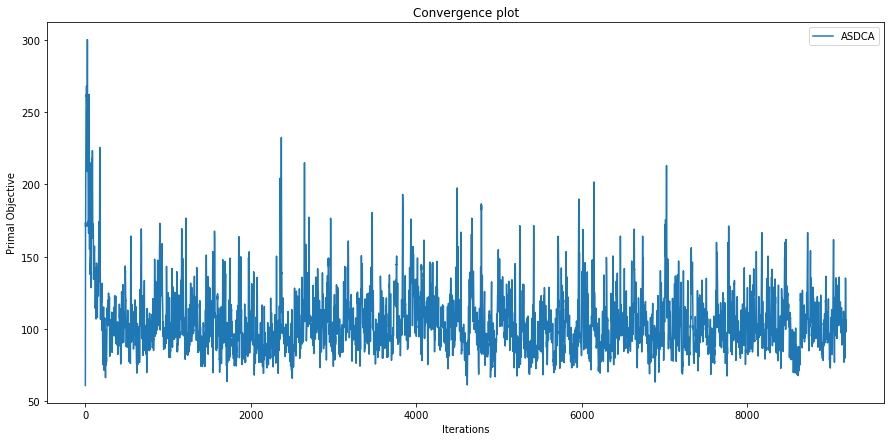

ASDCA
0.885869565217
Average
1.0


In [126]:
# ASDCA

lambdas = [10, 1, 0.1, 0.01, 0.001]
for l in lambdas :
    print("lambda = " + str(l))
    # calculs
    gen_opt_w_sdca_batch, gen_primal_hist_sdca_batch = SDCA_SVM_mini_batch(X_train_gen_std, y_train_gen, n_samples, T_0=50 * n_samples // 2, lambd=l, batch_size=8, theta=0.15, average=False)
    gen_opt_w_sdca_batch_avg, gen_w_hist_sdca_batch_avg, gen_primal_hist_sdca_batch_avg = SDCA_SVM_mini_batch(X_train_gen_std, y_train_gen, n_samples, T_0=50 * n_samples // 2, lambd=l, batch_size = 8, theta = 0.15, average=True)
    
    # plots
    histories_gen_sdca_batch = [gen_primal_hist_sdca_batch]
    labels_gen_sdca_batch = ["ASDCA"]
    comparaison_convergence_plot(histories_gen_sdca_batch, labels_gen_sdca_batch)

lambda = 10


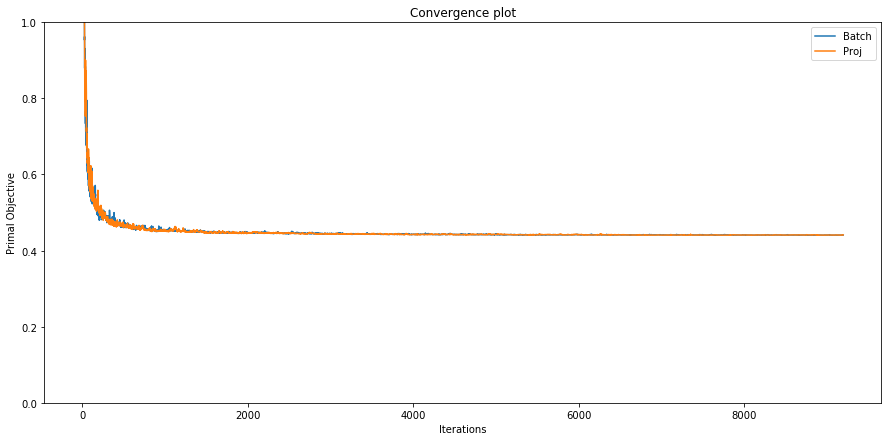

Batch
0.940217391304
Projected
0.940217391304
Average
0.951086956522
lambda = 1


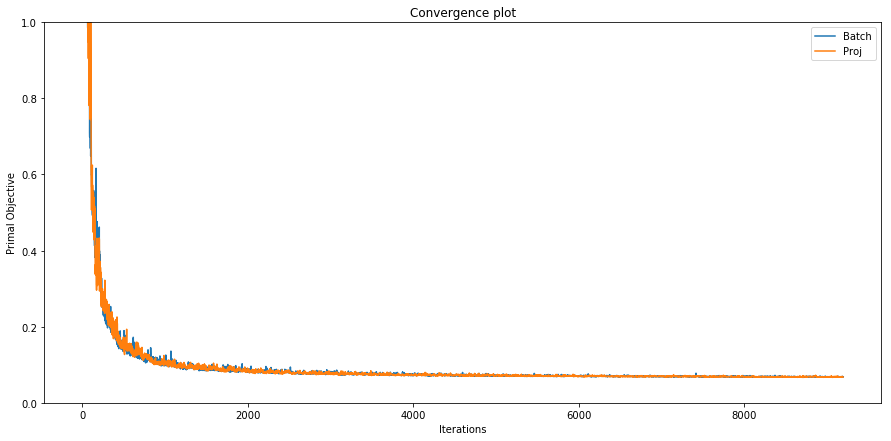

Batch
1.0
Projected
1.0
Average
1.0
lambda = 0.1


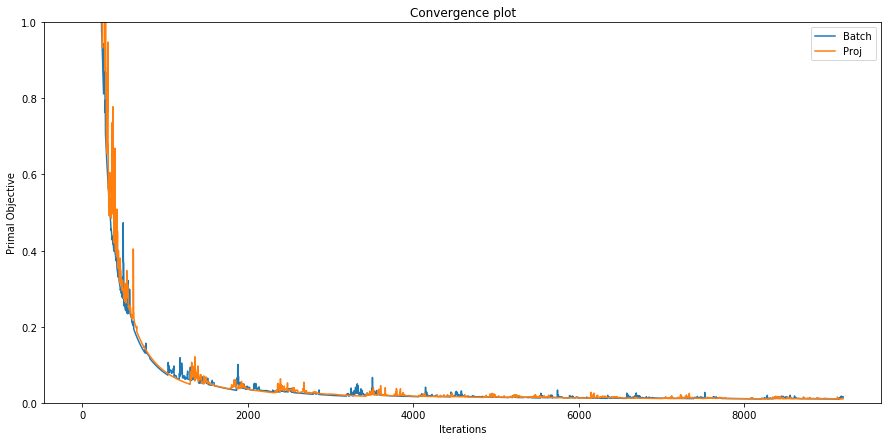

Batch
1.0
Projected
1.0
Average
1.0
lambda = 0.01


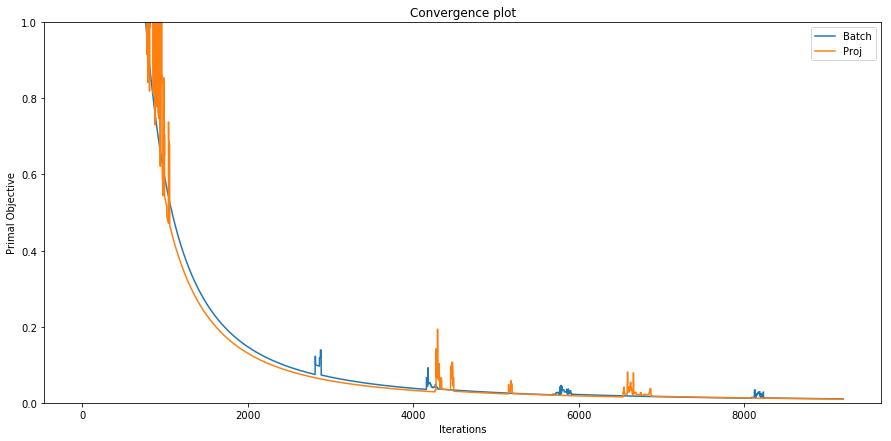

Batch
1.0
Projected
1.0
Average
1.0
lambda = 0.001


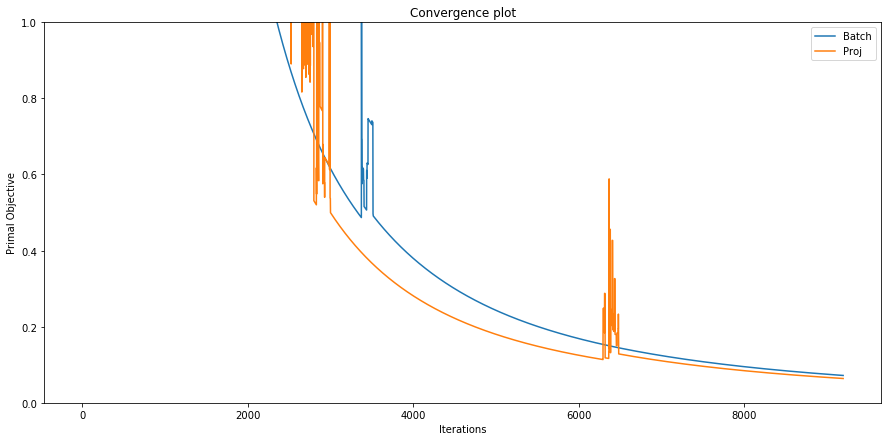

Batch
1.0
Projected
1.0
Average
1.0


In [127]:
# Mini-Batch Pegasos

lambdas = [10, 1, 0.1, 0.01, 0.001]
for l in lambdas :
    print("lambda = " + str(l))
    # calculs
    gen_opt_w_peg_batch,      gen_primal_hist_peg_batch      = PEGASOS_SVM_mini_batch(X_train_gen_std, y_train_gen, n_samples, T_0=50 * n_samples // 2, lambd=l, batch_size=8, proj=False, average=False)
    gen_opt_w_peg_batch_proj, gen_primal_hist_peg_batch_proj = PEGASOS_SVM_mini_batch(X_train_gen_std, y_train_gen, n_samples, T_0=50 * n_samples // 2, lambd=l, batch_size=8, proj=True, average=False)
    gen_opt_w_peg_batch_avg, gen_w_hist_peg_batch_avg, gen_primal_hist_peg_batch_avg = PEGASOS_SVM_mini_batch(X_train_gen_std, y_train_gen, n_samples, T_0=50 * n_samples // 2, lambd=l, batch_size=8, proj=False, average=True)
    
    # plots
    histories_gen_peg_batch = [gen_primal_hist_peg_batch, gen_primal_hist_peg_batch_proj]
    labels_gen_peg_batch = ["Batch", "Proj"]
    comparaison_convergence_plot(histories_gen_peg_batch, labels_gen_peg_batch, ylim=[0,1])

# IV. Skin segmentation data (large n)

Data are from the website : https://archive.ics.uci.edu/ml/datasets/Skin+Segmentation/

In [15]:
# For this dataset, keeping the loss history is a bad idea
# Since n is large, it will take much much longer if we compute the loss
# at each step
# As a benchmark, we keep it only for a small number of iterations

X_train_skin = pd.read_table("Skin_NonSkin.txt", header = None)[[0,1,2]]
y_train_skin = pd.read_table("Skin_NonSkin.txt", header = None)[3]
y_train_skin[y_train_skin == 2] = -1

In [16]:
n_samples = X_train_skin.shape[0]
X_train_skin_std = preprocessing.StandardScaler().fit_transform(X_train_skin)

In [17]:
X_train_skin.shape

(245057, 3)

## IV.1. SDCA

In [31]:
skin_opt_w_sdca_random, skin_primal_hist_sdca_random = SDCA_SVM(X_train_skin_std,
                                                    y_train_skin, n_samples, T_0=2 * n_samples // 2,
                                                    lambd=1 / n_samples, nb_epochs = 3, iteration="random",
                                                    average=False, keep_full_primal_history = False) 

In [54]:
skin_opt_w_sdca_permutation, skin_primal_hist_sdca_permutation = SDCA_SVM(X_train_skin_std, y_train_skin,
                                                                n_samples, T_0=3 * n_samples // 2,
                                                                lambd=1 / n_samples, nb_epochs = 3,
                                                                iteration="permutation", average=False,
                                                                keep_full_primal_history = False)

In [55]:
skin_opt_w_sdca_cyclic, skin_primal_hist_sdca_cyclic = SDCA_SVM(X_train_skin_std, y_train_skin, n_samples,
                                                        T_0=3 * n_samples // 2, lambd=1 / n_samples,
                                                        nb_epochs = 3, iteration="cyclic", average=False,
                                                        keep_full_primal_history = False)

/Users/satyasarma/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


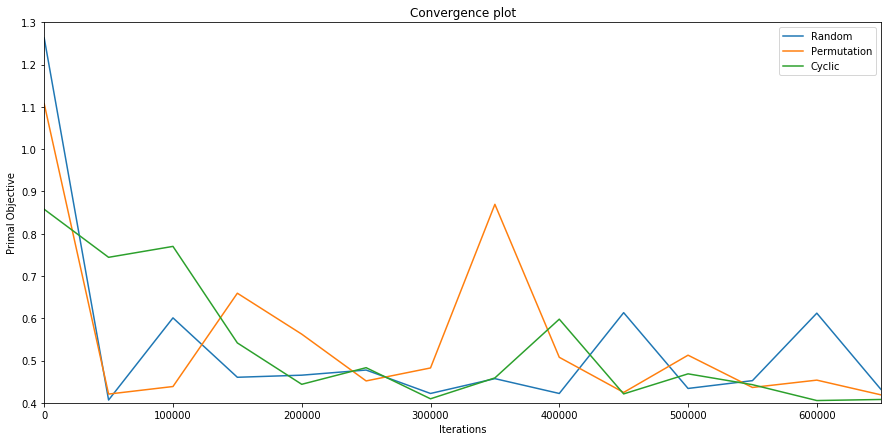

In [124]:
histories_skin_sdca = [skin_primal_hist_sdca_random, skin_primal_hist_sdca_permutation, skin_primal_hist_sdca_cyclic]
labels_skin_sdca = ["Random", "Permutation", "Cyclic"]
comparaison_convergence_plot(histories_skin_sdca, labels_skin_sdca, xlim = [0, 13], ylim=[0.4, 1.3],
                             xticklabels = np.arange(0, 750000, 100000))

## IV.2. Pegasos

In [25]:
skin_opt_w_peg, skin_primal_hist_peg = PEGASOS_SVM(X_train_skin_std, y_train_skin, n_samples,
                                        T_0=3 * n_samples // 2, lambd=1 / n_samples, nb_epochs = 3,
                                        proj=False, average=False, keep_full_primal_history = False)

In [26]:
skin_opt_w_peg_proj, skin_primal_hist_peg_proj = PEGASOS_SVM(X_train_skin_std, y_train_skin, n_samples,
                                                            T_0=3 * n_samples // 2, lambd=1 / n_samples,
                                                            nb_epochs = 3, proj=True, average=False,
                                                             keep_full_primal_history = False)

/Users/satyasarma/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


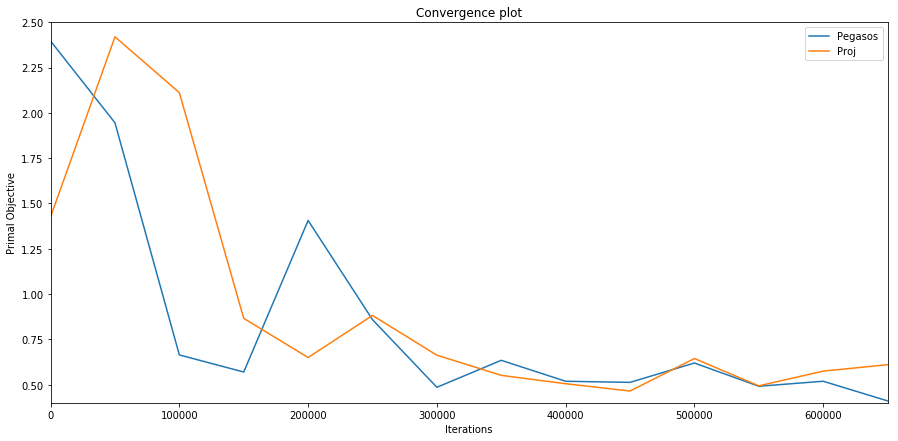

In [120]:
histories_skin_peg = [skin_primal_hist_peg, skin_primal_hist_peg_proj]
labels_skin_peg = ["Pegasos", "Proj"]
comparaison_convergence_plot(histories_skin_peg, labels_skin_peg, xlim = [0, 13], ylim=[0.4, 2.5],
                             xticklabels = np.arange(0, 750000, 100000))

## IV.3. ASDCA

In [46]:
skin_opt_w_sdca_batch, skin_primal_hist_sdca_batch = SDCA_SVM_mini_batch(X_train_skin_std, y_train_skin,
                                            n_samples, theta = 0.75, T_0 = 3*n_samples//2, lambd = 1/n_samples,
                                            average=False, nb_epochs = 3, batch_size = 2,
                                            keep_full_primal_history = False )

## IV.4. Mini-batch Pegasos

In [38]:
skin_opt_w_peg_batch, skin_primal_hist_peg_batch = PEGASOS_SVM_mini_batch(X_train_skin_std, y_train_skin,
                                        n_samples, T_0 = 3*n_samples//2, lambd = 1/n_samples, nb_epochs = 3,
                                        average=False, batch_size = 2, keep_full_primal_history = False )

# IV.5. Comparison between all four algorithms

/Users/satyasarma/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


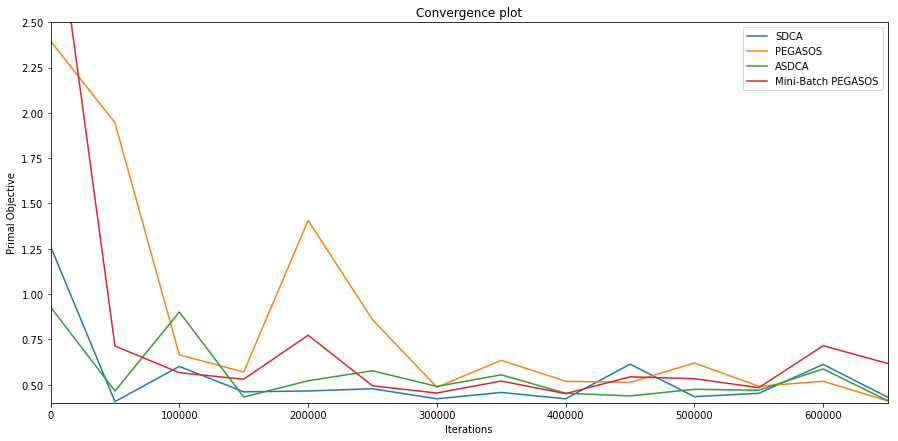

In [208]:
# All simulations
simu_histories = [skin_primal_hist_sdca_random, skin_primal_hist_peg, skin_primal_hist_sdca_batch, skin_primal_hist_peg_batch]
simu_labels = ["SDCA", "PEGASOS", "ASDCA", "Mini-Batch PEGASOS"]
comparaison_convergence_plot(simu_histories, simu_labels, xlim = [0, 13], ylim = [0.4, 2.5],
                             xticklabels = np.arange(0, 750000, 100000))